In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from scipy import signal
import scipy.signal as sg
from tqdm import tqdm
import os

from obspy.signal.filter import bandpass, lowpass, highpass

from hyperopt import hp, tpe, Trials, fmin
from librosa import power_to_db
import scipy.fftpack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection._search import ParameterGrid
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso,Ridge

import xgboost as xgb
import catboost as cb
from scipy.signal import welch

import tsfresh
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import feature_calculators

import eli5
from eli5.sklearn import PermutationImportance

import datetime

In [7]:
for k, v in ComprehensiveFCParameters().items():
    print(k, v)
    print()

variance_larger_than_standard_deviation None

has_duplicate_max None

has_duplicate_min None

has_duplicate None

sum_values None

abs_energy None

mean_abs_change None

mean_change None

mean_second_derivative_central None

median None

mean None

length None

standard_deviation None

variance None

skewness None

kurtosis None

absolute_sum_of_changes None

longest_strike_below_mean None

longest_strike_above_mean None

count_above_mean None

count_below_mean None

last_location_of_maximum None

first_location_of_maximum None

last_location_of_minimum None

first_location_of_minimum None

percentage_of_reoccurring_datapoints_to_all_datapoints None

percentage_of_reoccurring_values_to_all_values None

sum_of_reoccurring_values None

sum_of_reoccurring_data_points None

ratio_value_number_to_time_series_length None

sample_entropy None

maximum None

minimum None

time_reversal_asymmetry_statistic [{'lag': 1}, {'lag': 2}, {'lag': 3}]

c3 [{'lag': 1}, {'lag': 2}, {'lag': 3}]

cid_ce [{'

In [1]:
%%HTML
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 65%; }
   div#maintoolbar-container { width: 99%; }
</style>

In [3]:
df = pd.read_csv('data/train.csv', dtype={'acoustic_data': np.float64, 'time_to_failure': np.float64})

In [7]:
np.where(df['time_to_failure'].diff()>0)[0]

array([  5656574,  50085878, 104677356, 138772453, 187641820, 218652630,
       245829585, 307838917, 338276287, 375377848, 419368880, 461811623,
       495800225, 528777115, 585568144, 621985673])

In [17]:
st_idx = np.array([0,  5656574,  50085878, 104677356, 138772453, 187641820, 218652630,
       245829585, 307838917, 338276287, 375377848, 419368880, 461811623,
       495800225, 528777115, 585568144, 621985673])

In [19]:
end_idx = np.array([5656574,  50085878, 104677356, 138772453, 187641820, 218652630,
       245829585, 307838917, 338276287, 375377848, 419368880, 461811623,
       495800225, 528777115, 585568144, 621985673, 629145480])-1

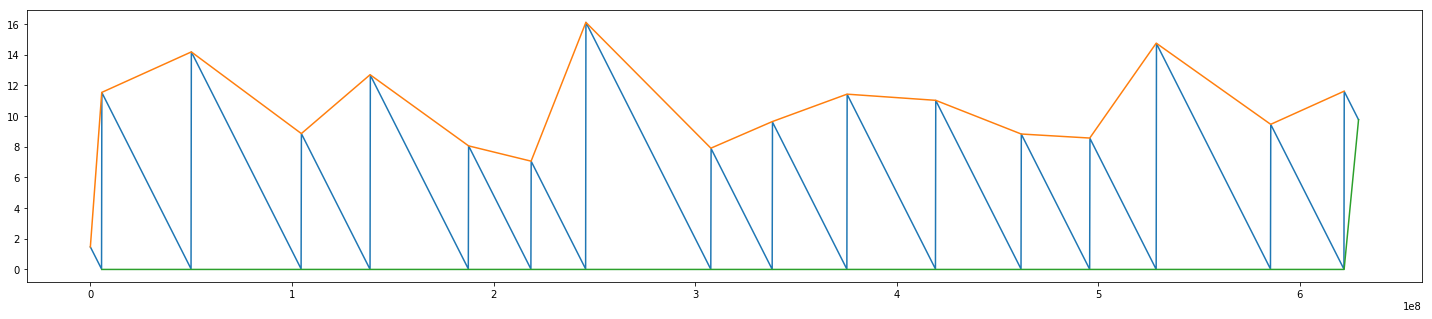

In [20]:
plt.figure(figsize=(25,5))
sns.lineplot(x=np.arange(df.shape[0])[::150000], y=df['time_to_failure'].values[::150000])
sns.lineplot(x=st_idx, y=df['time_to_failure'].values[st_idx])
sns.lineplot(x=end_idx, y=df['time_to_failure'].values[end_idx])

In [50]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

def rms_(X):
    return np.sqrt(np.mean(np.power(X,2)))

# relation with len
def rssq_(X):
    return np.sum(np.power(X,2))

def crest_factor_(X):
    return abs(max(X, key=abs))/(np.sqrt(np.mean(X**2)))

def peak_peak_amp_(X):
    return abs(max(X, key=abs)) - abs(min(X, key=abs))

def clearance_factor_(X):
    return abs(max(X, key=abs))/(np.mean(np.sqrt(abs(X)))**2)

def impluse_indicator_(X):
    return abs(max(X, key=abs))/(np.mean(abs(X)))


def impulse_factor_(X):
    return  peak_peak_amp_(X)/2/(np.sum(np.abs(X)) / len(X))

# 3rd moment
def skewness_(X):
    return scipy.stats.skew(X)

def kurtosis_(X):
    return scipy.stats.kurtosis(X)

def mean_(X):
    return np.mean(X)

def median_(X):
    return np.median(X)

def max_(X):
    return np.max(X)

def min_(X):
    return np.min(X)

def std_(X):
    return np.std(X)

def variance_(X):
    return np.var(X)

# relation with len
def entropy_(X):
    return scipy.stats.entropy(X)

def form_factor_(X):
    return rms_(X) / np.mean(np.abs(X))

# def moment_(X, moment):
#     return stats.moment(X, moment)

# relation with len
def no_zero_crossing_(X):
    return (np.diff(np.sign(X)) != 0).sum()

def peak_to_average_power_ratio_(X):
    return np.power(crest_factor_(X), 2)

def smoothness_(X):
    return 1 - 1 / (1 + np.power(std_(X), 2))

def quantile99(X):
    return np.quantile(X, 0.99)

def quantile95(X):
    return np.quantile(X, 0.95)

def quantile75(X):
    return np.quantile(X, 0.75)

def quantile25(X):
    return np.quantile(X, 0.25)

def quantile05(X):
    return np.quantile(X, 0.05)

def quantile01(X):
    return np.quantile(X, 0.01)

# def v_order(X, degree):
#     return np.power(np.sum(np.power(abs(X), degree))/len(data), 1/degree)

funcs = [rms_,rssq_,crest_factor_,peak_peak_amp_,
         clearance_factor_,impluse_indicator_,impulse_factor_,skewness_, kurtosis_, mean_, median_, max_, min_, std_, variance_, entropy_, mean_, 
         form_factor_,no_zero_crossing_,peak_to_average_power_ratio_,smoothness_,
        quantile99, quantile95, quantile75, quantile25, quantile05, quantile01]

CUTOFF = 18000
NY_FREQ_IDX = 75000
MAX_FREQ_IDX = 20000
FREQ_STEP = 2500
def des_bw_filter_lp(cutoff=CUTOFF):  # low pass filter
    b, a = sg.butter(4, Wn=cutoff/NY_FREQ_IDX)
    return b, a

def des_bw_filter_hp(cutoff=CUTOFF):  # high pass filter
    b, a = sg.butter(4, Wn=cutoff/NY_FREQ_IDX, btype='highpass')
    return b, a

def des_bw_filter_bp(low, high):  # band pass filter
    b, a = sg.butter(4, Wn=(low/NY_FREQ_IDX, high/NY_FREQ_IDX), btype='bandpass')
    return b, a

In [32]:
def extract_kaggle_features(x):
    
    df_features = pd.DataFrame()
    segment = 0
    
    for func in funcs:
        df_features.loc[segment, '{}'.format(func.__name__)] = func(x)
    
    for windows in [5000]:
        particle_feats = []
        splited_x = x.values.reshape(-1, windows)
        for particle in list(splited_x):
            dct = {}
            for func in funcs:
                dct['{}{}'.format(windows, func.__name__)] = func(particle)
            particle_feats.append(dct)
        df_particle_feats = pd.DataFrame(particle_feats)
        for col in  df_particle_feats.columns:
            for func in funcs:
                df_features.loc[segment, '{}{}'.format(col, func.__name__)] = func(df_particle_feats[col].values)
        
    df_features.loc[segment, 'mean'] = x.mean()
    df_features.loc[segment, 'std'] = x.std()
    df_features.loc[segment, 'max'] = x.max()
    df_features.loc[segment, 'min'] = x.min()
    
    df_features.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    df_features.loc[segment, 'mean_change_rate'] = calc_change_rate(x)
    df_features.loc[segment, 'abs_max'] = np.abs(x).max()
    df_features.loc[segment, 'abs_min'] = np.abs(x).min()
    
    df_features.loc[segment, 'std_first_50000'] = x[:50000].std()
    df_features.loc[segment, 'std_last_50000'] = x[-50000:].std()
    df_features.loc[segment, 'std_first_10000'] = x[:10000].std()
    df_features.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    df_features.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    df_features.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    df_features.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    df_features.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    df_features.loc[segment, 'min_first_50000'] = x[:50000].min()
    df_features.loc[segment, 'min_last_50000'] = x[-50000:].min()
    df_features.loc[segment, 'min_first_10000'] = x[:10000].min()
    df_features.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    df_features.loc[segment, 'max_first_50000'] = x[:50000].max()
    df_features.loc[segment, 'max_last_50000'] = x[-50000:].max()
    df_features.loc[segment, 'max_first_10000'] = x[:10000].max()
    df_features.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    df_features.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    df_features.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    df_features.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    df_features.loc[segment, 'sum'] = x.sum()
    
    df_features.loc[segment, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
    df_features.loc[segment, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
    df_features.loc[segment, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
    df_features.loc[segment, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
    df_features.loc[segment, 'q95'] = np.quantile(x,0.95)
    df_features.loc[segment, 'q99'] = np.quantile(x,0.99)
    df_features.loc[segment, 'q05'] = np.quantile(x,0.05)
    df_features.loc[segment, 'q01'] = np.quantile(x,0.01)
    
    df_features.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    df_features.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    df_features.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    df_features.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    df_features.loc[segment, 'trend'] = add_trend_feature(x)
    df_features.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    df_features.loc[segment, 'abs_mean'] = np.abs(x).mean()
    df_features.loc[segment, 'abs_std'] = np.abs(x).std()
    
#     df_features.loc[segment, 'mad'] = x.mad()
#     df_features.loc[segment, 'kurt'] = x.kurtosis()
#     df_features.loc[segment, 'skew'] = x.skew()
#     df_features.loc[segment, 'med'] = x.median()
    
    df_features.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    df_features.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    df_features.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    df_features.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    df_features.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    df_features.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    df_features.loc[segment, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
    df_features.loc[segment, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
    df_features.loc[segment, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
    df_features.loc[segment, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    df_features.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    
    ewma = pd.Series.ewm
    df_features.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    df_features.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    df_features.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    
    no_of_std = 3
    df_features.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    df_features.loc[segment,'MA_700MA_BB_high_mean'] = (df_features.loc[segment, 'Moving_average_700_mean'] + no_of_std * df_features.loc[segment, 'MA_700MA_std_mean']).mean()
    df_features.loc[segment,'MA_700MA_BB_low_mean'] = (df_features.loc[segment, 'Moving_average_700_mean'] - no_of_std * df_features.loc[segment, 'MA_700MA_std_mean']).mean()
    df_features.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    df_features.loc[segment,'MA_400MA_BB_high_mean'] = (df_features.loc[segment, 'Moving_average_700_mean'] + no_of_std * df_features.loc[segment, 'MA_400MA_std_mean']).mean()
    df_features.loc[segment,'MA_400MA_BB_low_mean'] = (df_features.loc[segment, 'Moving_average_700_mean'] - no_of_std * df_features.loc[segment, 'MA_400MA_std_mean']).mean()
    df_features.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    df_features.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    df_features.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    df_features.loc[segment, 'q999'] = np.quantile(x,0.999)
    df_features.loc[segment, 'q001'] = np.quantile(x,0.001)
    df_features.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        df_features.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        df_features.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        df_features.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        df_features.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        df_features.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        df_features.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        df_features.loc[segment, 'q25_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.25)
        df_features.loc[segment, 'q75_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.75)
        df_features.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        df_features.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        df_features.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        df_features.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        df_features.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        df_features.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        df_features.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        df_features.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        df_features.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        df_features.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        df_features.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        df_features.loc[segment, 'q25_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.25)
        df_features.loc[segment, 'q75_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.75)
        df_features.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        df_features.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        df_features.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        df_features.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        df_features.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
        
        for func in funcs:
            df_features.loc[segment, '{}{}'.format(func.__name__, '_roll_std')] = func(x_roll_std)
            df_features.loc[segment, '{}{}'.format(func.__name__, '_roll_mean')] = func(x_roll_mean)

    return df_features.iloc[0].T.to_dict()

In [63]:
def extract_kaggle_features2(seg):
    
    df_features = pd.DataFrame()
    seg_id = 0

    df_featuresc = pd.Series(seg)
    df_featurescdm = df_featuresc - np.mean(df_featuresc)

    b, a = des_bw_filter_lp(cutoff=18000)
    df_featurescz = sg.lfilter(b, a, df_featurescdm)

    zc = np.fft.fft(df_featurescz)
    zc = zc[:MAX_FREQ_IDX]

    # FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)

    freq_bands = [df_features for df_features in range(0, MAX_FREQ_IDX, FREQ_STEP)]
    magFFT = np.sqrt(realFFT ** 2 + imagFFT ** 2)
    phzFFT = np.arctan(imagFFT / realFFT)
    phzFFT[phzFFT == -np.inf] = -np.pi / 2.0
    phzFFT[phzFFT == np.inf] = np.pi / 2.0
    phzFFT = np.nan_to_num(phzFFT)

    for freq in freq_bands:
        df_features.loc[seg_id, 'FFT_Mag_01q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.01)
        df_features.loc[seg_id, 'FFT_Mag_05q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.05)
        df_features.loc[seg_id, 'FFT_Mag_10q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.1)
        df_features.loc[seg_id, 'FFT_Mag_25q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.25)
        df_features.loc[seg_id, 'FFT_Mag_75q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.75)
        df_features.loc[seg_id, 'FFT_Mag_90q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.9)
        df_features.loc[seg_id, 'FFT_Mag_95q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.95)
        df_features.loc[seg_id, 'FFT_Mag_99q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.99)
        df_features.loc[seg_id, 'FFT_Mag_mean%d' % freq] = np.mean(magFFT[freq: freq + FREQ_STEP])
        df_features.loc[seg_id, 'FFT_Mag_std%d' % freq] = np.std(magFFT[freq: freq + FREQ_STEP])
        df_features.loc[seg_id, 'FFT_Mag_max%d' % freq] = np.max(magFFT[freq: freq + FREQ_STEP])

        df_features.loc[seg_id, 'FFT_Phz_mean%d' % freq] = np.mean(phzFFT[freq: freq + FREQ_STEP])
        df_features.loc[seg_id, 'FFT_Phz_std%d' % freq] = np.std(phzFFT[freq: freq + FREQ_STEP])

    df_features.loc[seg_id, 'FFT_Rmean'] = realFFT.mean()
    df_features.loc[seg_id, 'FFT_Rstd'] = realFFT.std()
    df_features.loc[seg_id, 'FFT_Rmax'] = realFFT.max()
    df_features.loc[seg_id, 'FFT_Rmin'] = realFFT.min()
    df_features.loc[seg_id, 'FFT_Imean'] = imagFFT.mean()
    df_features.loc[seg_id, 'FFT_Istd'] = imagFFT.std()
    df_features.loc[seg_id, 'FFT_Imax'] = imagFFT.max()
    df_features.loc[seg_id, 'FFT_Imin'] = imagFFT.min()

    df_features.loc[seg_id, 'FFT_Rmean_first_6000'] = realFFT[:6000].mean()
    df_features.loc[seg_id, 'FFT_Rstd__first_6000'] = realFFT[:6000].std()
    df_features.loc[seg_id, 'FFT_Rmax_first_6000'] = realFFT[:6000].max()
    df_features.loc[seg_id, 'FFT_Rmin_first_6000'] = realFFT[:6000].min()
    df_features.loc[seg_id, 'FFT_Rmean_first_18000'] = realFFT[:18000].mean()
    df_features.loc[seg_id, 'FFT_Rstd_first_18000'] = realFFT[:18000].std()
    df_features.loc[seg_id, 'FFT_Rmax_first_18000'] = realFFT[:18000].max()
    df_features.loc[seg_id, 'FFT_Rmin_first_18000'] = realFFT[:18000].min()

    del df_featurescz
    del zc

    b, a = des_bw_filter_lp(cutoff=2500)
    df_featuresc0 = sg.lfilter(b, a, df_featurescdm)

    b, a = des_bw_filter_bp(low=2500, high=5000)
    df_featuresc1 = sg.lfilter(b, a, df_featurescdm)

    b, a = des_bw_filter_bp(low=5000, high=7500)
    df_featuresc2 = sg.lfilter(b, a, df_featurescdm)

    b, a = des_bw_filter_bp(low=7500, high=10000)
    df_featuresc3 = sg.lfilter(b, a, df_featurescdm)

    b, a = des_bw_filter_bp(low=10000, high=12500)
    df_featuresc4 = sg.lfilter(b, a, df_featurescdm)

    b, a = des_bw_filter_bp(low=12500, high=15000)
    df_featuresc5 = sg.lfilter(b, a, df_featurescdm)

    b, a = des_bw_filter_bp(low=15000, high=17500)
    df_featuresc6 = sg.lfilter(b, a, df_featurescdm)

    b, a = des_bw_filter_bp(low=17500, high=20000)
    df_featuresc7 = sg.lfilter(b, a, df_featurescdm)

    b, a = des_bw_filter_hp(cutoff=20000)
    df_featuresc8 = sg.lfilter(b, a, df_featurescdm)

    sigs = [df_featuresc, pd.Series(df_featuresc0), pd.Series(df_featuresc1), pd.Series(df_featuresc2), pd.Series(df_featuresc3),
            pd.Series(df_featuresc4), pd.Series(df_featuresc5), pd.Series(df_featuresc6), pd.Series(df_featuresc7), pd.Series(df_featuresc8)]

    for i, sig in enumerate(sigs):
        df_features.loc[seg_id, 'mean_%d' % i] = sig.mean()
        df_features.loc[seg_id, 'std_%d' % i] = sig.std()
        df_features.loc[seg_id, 'max_%d' % i] = sig.max()
        df_features.loc[seg_id, 'min_%d' % i] = sig.min()

        df_features.loc[seg_id, 'mean_change_abs_%d' % i] = np.mean(np.diff(sig))
        df_features.loc[seg_id, 'mean_change_rate_%d' % i] = np.mean(np.nonzero((np.diff(sig) / sig[:-1]))[0])
        df_features.loc[seg_id, 'abs_max_%d' % i] = np.abs(sig).max()
        df_features.loc[seg_id, 'abs_min_%d' % i] = np.abs(sig).min()

        df_features.loc[seg_id, 'std_first_50000_%d' % i] = sig[:50000].std()
        df_features.loc[seg_id, 'std_last_50000_%d' % i] = sig[-50000:].std()
        df_features.loc[seg_id, 'std_first_10000_%d' % i] = sig[:10000].std()
        df_features.loc[seg_id, 'std_last_10000_%d' % i] = sig[-10000:].std()

        df_features.loc[seg_id, 'avg_first_50000_%d' % i] = sig[:50000].mean()
        df_features.loc[seg_id, 'avg_last_50000_%d' % i] = sig[-50000:].mean()
        df_features.loc[seg_id, 'avg_first_10000_%d' % i] = sig[:10000].mean()
        df_features.loc[seg_id, 'avg_last_10000_%d' % i] = sig[-10000:].mean()

        df_features.loc[seg_id, 'min_first_50000_%d' % i] = sig[:50000].min()
        df_features.loc[seg_id, 'min_last_50000_%d' % i] = sig[-50000:].min()
        df_features.loc[seg_id, 'min_first_10000_%d' % i] = sig[:10000].min()
        df_features.loc[seg_id, 'min_last_10000_%d' % i] = sig[-10000:].min()

        df_features.loc[seg_id, 'max_first_50000_%d' % i] = sig[:50000].max()
        df_features.loc[seg_id, 'max_last_50000_%d' % i] = sig[-50000:].max()
        df_features.loc[seg_id, 'max_first_10000_%d' % i] = sig[:10000].max()
        df_features.loc[seg_id, 'max_last_10000_%d' % i] = sig[-10000:].max()

        df_features.loc[seg_id, 'max_to_min_%d' % i] = sig.max() / np.abs(sig.min())
        df_features.loc[seg_id, 'max_to_min_diff_%d' % i] = sig.max() - np.abs(sig.min())
        df_features.loc[seg_id, 'count_big_%d' % i] = len(sig[np.abs(sig) > 500])
        df_features.loc[seg_id, 'sum_%d' % i] = sig.sum()

        df_features.loc[seg_id, 'mean_change_rate_first_50000_%d' % i] = np.mean(np.nonzero((np.diff(sig[:50000]) / sig[:50000][:-1]))[0])
        df_features.loc[seg_id, 'mean_change_rate_last_50000_%d' % i] = np.mean(np.nonzero((np.diff(sig[-50000:]) / sig[-50000:][:-1]))[0])
        df_features.loc[seg_id, 'mean_change_rate_first_10000_%d' % i] = np.mean(np.nonzero((np.diff(sig[:10000]) / sig[:10000][:-1]))[0])
        df_features.loc[seg_id, 'mean_change_rate_last_10000_%d' % i] = np.mean(np.nonzero((np.diff(sig[-10000:]) / sig[-10000:][:-1]))[0])

        df_features.loc[seg_id, 'q75_%d' % i] = np.quantile(sig, 0.75)
        df_features.loc[seg_id, 'q95_%d' % i] = np.quantile(sig, 0.95)
        df_features.loc[seg_id, 'q99_%d' % i] = np.quantile(sig, 0.99)
        df_features.loc[seg_id, 'q25_%d' % i] = np.quantile(sig, 0.25)
        df_features.loc[seg_id, 'q05_%d' % i] = np.quantile(sig, 0.05)
        df_features.loc[seg_id, 'q01_%d' % i] = np.quantile(sig, 0.01)

        df_features.loc[seg_id, 'abs_q75_%d' % i] = np.quantile(np.abs(sig), 0.75)
        df_features.loc[seg_id, 'abs_q95_%d' % i] = np.quantile(np.abs(sig), 0.95)
        df_features.loc[seg_id, 'abs_q99_%d' % i] = np.quantile(np.abs(sig), 0.99)
        df_features.loc[seg_id, 'abs_q25_%d' % i] = np.quantile(np.abs(sig), 0.25)
        df_features.loc[seg_id, 'abs_q05_%d' % i] = np.quantile(np.abs(sig), 0.05)
        df_features.loc[seg_id, 'abs_q01_%d' % i] = np.quantile(np.abs(sig), 0.01)

        df_features.loc[seg_id, 'trend_%d' % i] = add_trend_feature(sig)
        df_features.loc[seg_id, 'abs_trend_%d' % i] = add_trend_feature(sig, abs_values=True)
        df_features.loc[seg_id, 'abs_mean_%d' % i] = np.abs(sig).mean()
        df_features.loc[seg_id, 'abs_std_%d' % i] = np.abs(sig).std()

        df_features.loc[seg_id, 'mad_%d' % i] = sig.mad()
        df_features.loc[seg_id, 'kurt_%d' % i] = sig.kurtosis()
        df_features.loc[seg_id, 'skew_%d' % i] = sig.skew()
        df_features.loc[seg_id, 'med_%d' % i] = sig.median()

        df_features.loc[seg_id, 'Hilbert_mean_%d' % i] = np.abs(hilbert(sig)).mean()
        df_features.loc[seg_id, 'Hann_window_mean2'] = (convolve(df_featuresc, hann(150), mode='same') / sum(hann(150))).mean()

        df_features.loc[seg_id, 'classic_sta_lta1_mean_%d' % i] = classic_sta_lta(sig, 500, 10000).mean()
        df_features.loc[seg_id, 'classic_sta_lta2_mean_%d' % i] = classic_sta_lta(sig, 5000, 100000).mean()
        df_features.loc[seg_id, 'classic_sta_lta3_mean_%d' % i] = classic_sta_lta(sig, 3333, 6666).mean()
        df_features.loc[seg_id, 'classic_sta_lta4_mean_%d' % i] = classic_sta_lta(sig, 10000, 25000).mean()

        df_features.loc[seg_id, 'Moving_average_700_mean_%d' % i] = sig.rolling(window=700).mean().mean(skipna=True)
        df_features.loc[seg_id, 'Moving_average_1500_mean_%d' % i] = sig.rolling(window=1500).mean().mean(skipna=True)
        df_features.loc[seg_id, 'Moving_average_3000_mean_%d' % i] = sig.rolling(window=3000).mean().mean(skipna=True)
        df_features.loc[seg_id, 'Moving_average_6000_mean_%d' % i] = sig.rolling(window=6000).mean().mean(skipna=True)

        ewma = pd.Series.ewm
        df_features.loc[seg_id, 'edf_featuresp_Moving_average_300_mean_%d' % i] = ewma(sig, span=300).mean().mean(skipna=True)
        df_features.loc[seg_id, 'edf_featuresp_Moving_average_3000_mean_%d' % i] = ewma(sig, span=3000).mean().mean(skipna=True)
        df_features.loc[seg_id, 'edf_featuresp_Moving_average_30000_mean_%d' % i] = ewma(sig, span=6000).mean().mean(skipna=True)

        no_of_std = 2
        df_features.loc[seg_id, 'MA_700MA_std_mean_%d' % i] = sig.rolling(window=700).std().mean()
        df_features.loc[seg_id, 'MA_700MA_BB_high_mean_%d' % i] = (
                    df_features.loc[seg_id, 'Moving_average_700_mean_%d' % i] + no_of_std * df_features.loc[seg_id, 'MA_700MA_std_mean_%d' % i]).mean()
        df_features.loc[seg_id, 'MA_700MA_BB_low_mean_%d' % i] = (
                    df_features.loc[seg_id, 'Moving_average_700_mean_%d' % i] - no_of_std * df_features.loc[seg_id, 'MA_700MA_std_mean_%d' % i]).mean()
        df_features.loc[seg_id, 'MA_400MA_std_mean_%d' % i] = sig.rolling(window=400).std().mean()
        df_features.loc[seg_id, 'MA_400MA_BB_high_mean_%d' % i] = (
                    df_features.loc[seg_id, 'Moving_average_700_mean_%d' % i] + no_of_std * df_features.loc[seg_id, 'MA_400MA_std_mean_%d' % i]).mean()
        df_features.loc[seg_id, 'MA_400MA_BB_low_mean_%d' % i] = (
                    df_features.loc[seg_id, 'Moving_average_700_mean_%d' % i] - no_of_std * df_features.loc[seg_id, 'MA_400MA_std_mean_%d' % i]).mean()
        df_features.loc[seg_id, 'MA_1000MA_std_mean_%d' % i] = sig.rolling(window=1000).std().mean()

        df_features.loc[seg_id, 'iqr_%d' % i] = np.subtract(*np.percentile(sig, [75, 25]))
        df_features.loc[seg_id, 'q999_%d' % i] = np.quantile(sig, 0.999)
        df_features.loc[seg_id, 'q001_%d' % i] = np.quantile(sig, 0.001)
        df_features.loc[seg_id, 'ave10_%d' % i] = stats.trim_mean(sig, 0.1)


    return df_features.iloc[0].T.to_dict()

In [25]:
func_tooslow =  [ 'sample_entropy','partial_autocorrelation','number_cwt_peaks', 'approximate_entropy', 'augmented_dickey_fuller', 'agg_linear_trend']

In [76]:
normal_parameters ={}
slow_parameters = {}
for k in ComprehensiveFCParameters().keys():
    if k in func_tooslow:
        pass
#         slow_parameters[k] = ComprehensiveFCParameters()[k]
    else:
        normal_parameters[k] = ComprehensiveFCParameters()[k]

In [77]:
for k in [ 'partial_autocorrelation','number_cwt_peaks', 'agg_linear_trend']:
    slow_parameters[k] = ComprehensiveFCParameters()[k]

In [78]:
len(normal_parameters),len(slow_parameters),len(ComprehensiveFCParameters())

(57, 3, 63)

In [30]:
def extract_tsfresh_feats(x, parameters):
    dct_fcp = parameters.copy()
    dct_feats = {}
    for k in dct_fcp.keys():
        try:
            func = getattr(feature_calculators, k)
            p = dct_fcp[k]
            if p == None:
                res = func(x)
            elif 'param' in func.__code__.co_varnames:
                res = func(x, p)
                for res_i in res:
                    dct_feats['{}{}'.format(k,res_i[0])] = res_i[1]
            else:
                for p_i in p:
                    res = func(x, **p_i)
                    dct_feats['{}{}'.format(k,p_i)] = res
        except Exception as e:
            raise Exception(k, p)
        
    return dct_feats

In [111]:
def extract_add_features(x):
    df_features = pd.DataFrame()
    segment = 0
    for windows in [25, 50, 75]:
        x_roll_std = x.rolling(windows).std().dropna().values
        df_features.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        df_features.loc[segment, 'q10_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.10)
        df_features.loc[segment, 'q15_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.15)
        df_features.loc[segment, 'q20_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.20)
        df_features.loc[segment, 'q25_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.25)
    return df_features.iloc[0].T.to_dict()
    

In [112]:
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height (if parameter
        `valley` is False) or peaks that are smaller than maximum peak height
         (if parameter `valley` is True).
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=-1.2, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)

    Version history
    ---------------
    '1.0.5':
        The sign of `mph` is inverted if parameter `valley` is True
    
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
        if mph is not None:
            mph = -mph
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
            if mph is not None:
                mph = -mph
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind

def psd_toppeak(x, n, fs, nperseg):
    f_values, psd_values = welch(x, fs=fs, nperseg=nperseg)
    peak_idx = detect_peaks(psd_values)
    sorted_idx = np.argsort(psd_values[peak_idx])[::-1]
    return f_values[peak_idx][sorted_idx][:n], psd_values[peak_idx][sorted_idx][:n]

def extract_add_features2(x):
    f_values, psd_values = psd_toppeak(x, 5, sr, 256)
    
    res = {}
    for a,b in (feature_calculators.spkt_welch_density(pd.Series(x), [{"coeff": i} for i in range(129)])):
        res['spkt_welch_density__{}'.format(a)] = b
    
    
    for idx, (f_v , psd_v) in enumerate(zip(f_values, psd_values)):
        res['{}th_peak_freq'.format(idx+1)] = f_v
        res['{}th_peak_psd'.format(idx+1)] = psd_v
    return res

In [35]:
%%time
a = extract_kaggle_features(pd.Series(df_sample.raw.values[0]))
len(a)

/home/ubuntu/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/home/ubuntu/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
/home/ubuntu/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/home/ubuntu/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
/home/ubuntu/.conda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:969: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
/home/ubuntu/.conda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/ubuntu/.conda/envs/py36/lib/python3.6/site-packag

CPU times: user 5 s, sys: 3.01 s, total: 8.01 s
Wall time: 4.48 s


In [64]:
%%time
b = extract_kaggle_features2(pd.Series(df_sample.raw.values[0]))
len(b)

/home/ubuntu/.conda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


CPU times: user 4.76 s, sys: 360 ms, total: 5.12 s
Wall time: 4.62 s


In [52]:
%%time
c = extract_tsfresh_feats(df_sample.raw.values[0], normal_parameters)
len(c)

CPU times: user 41.8 s, sys: 27.4 s, total: 1min 9s
Wall time: 38.8 s


In [53]:
%%time
d = extract_tsfresh_feats(df_sample.raw.values[0][::20], slow_parameters)
len(d)

CPU times: user 1min 41s, sys: 35.1 s, total: 2min 17s
Wall time: 1min 45s


In [101]:
%%time
e = extract_add_features(pd.Series(df_sample.raw.values[0]))
len(e)

CPU times: user 88 ms, sys: 16 ms, total: 104 ms
Wall time: 95.6 ms


In [104]:
%%time
f = extract_add_features2(pd.Series(df_sample.raw.values[0]))
len(f)

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 25.8 ms


In [65]:
len(a), len(b), len(c), len(d), np.sum([len(a), len(b), len(c), len(d)])

(900, 871, 693, 68, 2532)

In [66]:
len(set(list(a.keys())+list(b.keys())+list(c.keys())+list(d.keys())))

2532

In [22]:
samples = []
rows = 150_000
hop_rows = rows//8
# segments = int((df.shape[0])/rows)
i = 0
for seg_i_st_idx, seg_i_end_idx in zip(st_idx, end_idx):
    i += 1
    for index in range(seg_i_st_idx, seg_i_end_idx-rows, hop_rows):
        try:
            seg = df.iloc[index:index+rows]
            x = seg['acoustic_data'].values
            y = seg['time_to_failure'].values[-1]
            samples.append({'raw':x,'y':y,'index':index, 'season':i})
        except Exception as e:
            raise Exception('{}-{}-{}'.format(i, segment, seg.shape))
df_sample = pd.DataFrame(samples)
del samples

In [67]:
from multiprocessing import Pool, Value, Manager
from multiprocessing import Queue as PQueue
import multiprocessing
import numpy as np
import time
import sys

class VCParallel(object):

    '''
    generate samples from some data structure
    '''
    def run(self, iterable_obj, n_jobs=-1):
        
        try:
            iter(iterable_obj)
        except Exception as e:
            raise Exception(e.__str__())
            
        X = Manager().list()
        if n_jobs == -1:
            import multiprocessing
            n_jobs = multiprocessing.cpu_count()
        pool = Pool(n_jobs)
        
        params = []
        for item in iterable_obj:
            params.append((X, item))
        pool.starmap(self.worker, params)
        pool.close()
        pool.join()
        return pd.DataFrame(list(X))


    def worker(self, X, item, **kwargs):
        raise Exception('no inheritance')

In [68]:
print(df_sample.shape)
next(df_sample.iterrows())

(33426, 4)


(0, index                                                     0
 raw       [12.0, 6.0, 8.0, 5.0, 8.0, 8.0, 9.0, 7.0, -5.0...
 season                                                    1
 y                                                    1.4308
 Name: 0, dtype: object)

In [79]:
%%time

sr = 4000000
import warnings
warnings.filterwarnings("ignore")

class ParallelGenTSF(VCParallel):
    
    def __init__(self, ):
        return
    
    def worker(self, X, item,  **kwargs):
        
        try:
            index = item[1][0]
            x = item[1][1]
#             print(index, x.shape)
            
            part1 = extract_kaggle_features(pd.Series(x))
            part2 = extract_kaggle_features2(pd.Series(x))
            part3 = extract_tsfresh_feats(x, normal_parameters)
            part4 = extract_tsfresh_feats(x[::20], slow_parameters)
            
            X.append({'index':index, **part1, **part2, **part3, **part4})
        except Exception as e :
            print(item , e.__str__())
            raise Exception()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.32 ms


In [115]:
%%time

sr = 4000000
import warnings
warnings.filterwarnings("ignore")

class ParallelGenTSF(VCParallel):
    
    def __init__(self, ):
        return
    
    def worker(self, X, item,  **kwargs):
        
        try:
            index = item[1][0]
            x = item[1][1]
#             print(index, x.shape)

            part5 = extract_add_features(pd.Series(x))
            part6 = extract_add_features2(pd.Series(x))
            
            X.append({'index':index, **part5, **part6})
        except Exception as e :
            print(item , e.__str__())
            raise Exception()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.48 ms


In [116]:
%%time
df_train_add = ParallelGenTSF().run(df_sample.iterrows(), n_jobs=32)

CPU times: user 55.3 s, sys: 1min 10s, total: 2min 6s
Wall time: 3min 53s


In [118]:
df_train_add = df_train_add.sort_values(by=['index'])
df_train_add = df_train_add.reset_index(drop=True)

In [119]:
%%time

import warnings
warnings.filterwarnings("ignore")
class ParallelGenTSF(VCParallel):
    
    def worker(self, X, item, **kwargs):
        
        try:
            file = item
            df_test_i = pd.read_csv(test_file_path+file)
            x = df_test_i['acoustic_data'].values
            
            part5 = extract_add_features(pd.Series(x))
            part6 = extract_add_features2(pd.Series(x))
            
            X.append({'index':file.replace('.csv',''), **part5, **part6})
        except Exception as e :
            print(item , e.__str__())

test_file_path = 'data/test/'
df_test_add = ParallelGenTSF().run(sorted(os.listdir(test_file_path)), n_jobs=32)

warnings.filterwarnings("default")

CPU times: user 1.33 s, sys: 3.52 s, total: 4.85 s
Wall time: 24.3 s


In [120]:
df_test_add = df_test_add.sort_values(by=['index'])
df_test_add = df_test_add.reset_index(drop=True)

In [122]:
df_train_add.to_pickle('feats2/df_train_add.pkl')
df_test_add.to_pickle('feats2/df_test_add.pkl')

In [80]:
df_train = pd.DataFrame()

In [81]:
segment = df_sample.shape[0]//100
segments = df_sample.shape[0]
for segments_i in tqdm(range(0, segments, segment)):
    start = segments_i
    end = segments_i+segment if segments_i+segment < segments else segments
    df_train_i = ParallelGenTSF().run(df_sample.iloc[start:end,:].iterrows(), n_jobs=60)
    df_train = pd.concat([df_train, df_train_i], axis=0)
    df_train.to_pickle('feats2/features.pkl')




  0%|          | 0/101 [00:00<?, ?it/s]


  1%|          | 1/101 [11:38<19:24:51, 698.91s/it]


  2%|▏         | 2/101 [23:11<19:07:42, 695.58s/it]


  3%|▎         | 3/101 [34:42<18:53:53, 694.22s/it]


  4%|▍         | 4/101 [46:14<18:41:22, 693.64s/it]


  5%|▍         | 5/101 [57:52<18:31:19, 694.57s/it]


  6%|▌         | 6/101 [1:09:30<18:20:28, 695.03s/it]


  7%|▋         | 7/101 [1:21:07<18:09:29, 695.42s/it]


  8%|▊         | 8/101 [1:32:44<17:58:09, 695.59s/it]


  9%|▉         | 9/101 [1:44:22<17:46:58, 695.85s/it]


 10%|▉         | 10/101 [1:55:55<17:34:57, 695.58s/it]


 11%|█         | 11/101 [2:07:29<17:23:02, 695.36s/it]


 12%|█▏        | 12/101 [2:19:01<17:11:08, 695.15s/it]


 13%|█▎        | 13/101 [2:30:34<16:59:13, 694.93s/it]


 14%|█▍        | 14/101 [2:42:03<16:47:02, 694.51s/it]


 15%|█▍        | 15/101 [2:53:39<16:35:40, 694.66s/it]


 16%|█▌        | 16/101 [3:05:18<16:24:24, 694.88s/it]


 17%|█▋        | 17/101 [3:16:51<16:12:40, 694.77s/it]


 18%|

In [83]:
df_train = df_train.sort_values(by=['index'])
df_train = df_train.reset_index(drop=True)

In [85]:
df_train.to_pickle('feats2/features.pkl')

In [86]:
%%time

import warnings
warnings.filterwarnings("ignore")
class ParallelGenTSF(VCParallel):
    
    def worker(self, X, item, **kwargs):
        
        try:
            file = item
            df_test_i = pd.read_csv(test_file_path+file)
            x = df_test_i['acoustic_data'].values
            
            part1 = extract_kaggle_features(pd.Series(x))
            part2 = extract_kaggle_features2(pd.Series(x))
            part3 = extract_tsfresh_feats(x, normal_parameters)
            part4 = extract_tsfresh_feats(x[::20], slow_parameters)
            
            X.append({'index':file.replace('.csv',''), **part1, **part2, **part3, **part4})
        except Exception as e :
            print(item , e.__str__())



# warnings.filterwarnings("default")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 746 µs


In [87]:
test_file_path = 'data/test/'
df_test = ParallelGenTSF().run(sorted(os.listdir(test_file_path)), n_jobs=60)

In [90]:
df_test = df_test.sort_values(by=['index'])
df_test = df_test.reset_index(drop=True)

In [91]:
df_test.to_pickle('feats2/test_features.pkl')

In [92]:
df_sample = df_sample.sort_values(by=['index'])
df_sample = df_sample.reset_index(drop=True)

In [94]:
df_sample[['index','season','y']].to_pickle('feats2/sample.pkl')

In [8]:
df_train = pd.read_pickle('../feats2/train_features.pkl')
df_test = pd.read_pickle('../feats2/test_features.pkl')
df_sample = pd.read_pickle('../feats2/sample.pkl')
df_sample = df_sample.sort_values(by=['index'])
df_sample = df_sample.reset_index(drop=True)
df_train = pd.merge(df_train, df_sample, on='index')

In [24]:
df_sample.head()

,index,season,y
0,0,1,1.430797
1,18750,1,1.425499
2,37500,1,1.421296
3,56250,1,1.415898
4,75000,1,1.411696


In [16]:
nullcolumns = []
for col, nullcount in zip(df_train.columns, df_train.isnull().sum()):
    if nullcount!=0:
        nullcolumns.append(col)
        
for col, nullcount in zip(df_test.columns, df_test.isnull().sum()):
    if nullcount!=0:
        if col not in nullcolumns:
            print(col , 'only in df_test')
            nullcolumns.append(col)

nullcolumns

5000rssq_crest_factor_ only in df_test
5000rssq_form_factor_ only in df_test
5000rssq_peak_to_average_power_ratio_ only in df_test
5000rssq_rms_ only in df_test


['5000entropy_clearance_factor_',
 '5000entropy_crest_factor_',
 '5000entropy_entropy_',
 '5000entropy_form_factor_',
 '5000entropy_impluse_indicator_',
 '5000entropy_impulse_factor_',
 '5000entropy_kurtosis_',
 '5000entropy_peak_peak_amp_',
 '5000entropy_peak_to_average_power_ratio_',
 '5000entropy_skewness_',
 '5000entropy_smoothness_',
 '5000entropy_std_',
 '5000entropy_variance_',
 '5000quantile05entropy_',
 '5000quantile25entropy_',
 'friedrich_coefficientsm_3__r_30__coeff_0',
 'friedrich_coefficientsm_3__r_30__coeff_1',
 'friedrich_coefficientsm_3__r_30__coeff_2',
 'friedrich_coefficientsm_3__r_30__coeff_3',
 "max_langevin_fixed_point{'m': 3, 'r': 30}",
 '5000rssq_crest_factor_',
 '5000rssq_form_factor_',
 '5000rssq_peak_to_average_power_ratio_',
 '5000rssq_rms_']

In [18]:
df_train = df_train.drop(columns=nullcolumns)
df_test = df_test.drop(columns=nullcolumns)

In [17]:
boolcolumns = []
for col, typ in zip(df_train.columns, [type(v) for v in list(df_train.values[0,:])]):
    if typ == bool:
        boolcolumns.append(col)
        
for col, typ in zip(df_test.columns, [type(v) for v in list(df_test.values[0,:])]):
    if typ == bool:
        if col not in boolcolumns:
            print(col , 'only in df_test')
            boolcolumns.append(col)

boolcolumns

["large_standard_deviation{'r': 0.05}",
 "large_standard_deviation{'r': 0.15000000000000002}",
 "large_standard_deviation{'r': 0.1}",
 "large_standard_deviation{'r': 0.25}",
 "large_standard_deviation{'r': 0.2}",
 "large_standard_deviation{'r': 0.30000000000000004}",
 "large_standard_deviation{'r': 0.35000000000000003}",
 "large_standard_deviation{'r': 0.45}",
 "large_standard_deviation{'r': 0.4}",
 "large_standard_deviation{'r': 0.55}",
 "large_standard_deviation{'r': 0.5}",
 "large_standard_deviation{'r': 0.6000000000000001}",
 "large_standard_deviation{'r': 0.65}",
 "large_standard_deviation{'r': 0.7000000000000001}",
 "large_standard_deviation{'r': 0.75}",
 "large_standard_deviation{'r': 0.8500000000000001}",
 "large_standard_deviation{'r': 0.8}",
 "large_standard_deviation{'r': 0.9500000000000001}",
 "large_standard_deviation{'r': 0.9}",
 'symmetry_lookingr_0.0',
 'symmetry_lookingr_0.05',
 'symmetry_lookingr_0.1',
 'symmetry_lookingr_0.15000000000000002',
 'symmetry_lookingr_0.2'

In [19]:
for col in boolcolumns:
    df_train[col] = df_train[col].astype(int)
    df_test[col] = df_test[col].astype(int)

In [22]:
infcolumns = []

for col, infcount in zip(df_train.columns, df_train.replace([np.inf, -np.inf], np.nan).isnull().sum()):
    if infcount!=0:
        if col not in infcolumns:
            infcolumns.append(col)

for col, infcount in zip(df_test.columns, df_test.replace([np.inf, -np.inf], np.nan).isnull().sum()):
    if infcount!=0:
        if col not in infcolumns:
            print(col , 'only in df_test')
            infcolumns.append(col)

infcolumns

['5000entropy_max_',
 '5000entropy_mean_',
 '5000entropy_median_',
 '5000entropy_min_',
 '5000entropy_quantile01',
 '5000entropy_quantile05',
 '5000entropy_quantile25',
 '5000entropy_quantile75',
 '5000entropy_quantile95',
 '5000entropy_quantile99',
 '5000entropy_rms_',
 '5000entropy_rssq_',
 '5000kurtosis_entropy_',
 '5000mean_entropy_',
 '5000median_entropy_',
 '5000skewness_entropy_',
 'entropy_',
 'entropy__roll_mean']

In [23]:
df_train = df_train.drop(columns=infcolumns)
df_test = df_test.drop(columns=infcolumns)

In [123]:
df_train = pd.read_pickle('feats2/df_train.pkl')

In [124]:
df_train = pd.merge(df_train, df_train_add, on='index')

In [125]:
df_test = pd.read_pickle('feats2/df_test.pkl')

In [126]:
df_test = pd.merge(df_test, df_test_add, on='index')

In [130]:
len(features)

1838

In [127]:
features = df_train.columns.drop(['index','y','season']).tolist()
df_coor = pd.DataFrame(StandardScaler().fit_transform(df_train[features].values), columns=features).corr()
cocef = .99
grouped_col_lst = []
group = {}
for col in df_coor.columns:
    if col in grouped_col_lst:
        continue
    group[col] = list(df_coor[(df_coor[col]>cocef)|(df_coor[col]<-cocef)].index)
    grouped_col_lst +=  list(df_coor[(df_coor[col]>cocef)|(df_coor[col]<-cocef)].index)


In [128]:
for k, v in group.items():
    if len(v) > 1:
        print(k, v)

abs_q25_5 ['abs_q25_5', 'q20_roll_std_25', 'q25_roll_std_25']
q05_roll_std_100 ['q05_roll_std_100', 'q05_roll_std_25', 'q05_roll_std_50', 'q05_roll_std_75', 'q10_roll_std_25', 'q10_roll_std_50', 'q10_roll_std_75', 'q15_roll_std_25', 'q15_roll_std_50', 'q15_roll_std_75']
q25_roll_std_100 ['q25_roll_std_100', 'q15_roll_std_75', 'q20_roll_std_25', 'q20_roll_std_50', 'q20_roll_std_75', 'q25_roll_std_25', 'q25_roll_std_50', 'q25_roll_std_75']
spkt_welch_densitycoeff_2 ['spkt_welch_densitycoeff_2', 'spkt_welch_density__coeff_2']
spkt_welch_densitycoeff_5 ['spkt_welch_densitycoeff_5', 'spkt_welch_density__coeff_5']
spkt_welch_densitycoeff_8 ['spkt_welch_densitycoeff_8', 'spkt_welch_density__coeff_8']


In [131]:
features =  list(group.keys())

In [132]:
len(features)

1820

In [133]:
df_train = df_train[features+['y','index','season']]

In [134]:
df_test = df_test[features+['index']]

In [135]:
df_train.to_pickle('feats2/df_train.pkl')

In [136]:
df_test.to_pickle('feats2/df_test.pkl')

In [137]:
df_train_add.columns.tolist()

['1th_peak_freq',
 '1th_peak_psd',
 '2th_peak_freq',
 '2th_peak_psd',
 '3th_peak_freq',
 '3th_peak_psd',
 '4th_peak_freq',
 '4th_peak_psd',
 '5th_peak_freq',
 '5th_peak_psd',
 'index',
 'q05_roll_std_25',
 'q05_roll_std_50',
 'q05_roll_std_75',
 'q10_roll_std_25',
 'q10_roll_std_50',
 'q10_roll_std_75',
 'q15_roll_std_25',
 'q15_roll_std_50',
 'q15_roll_std_75',
 'q20_roll_std_25',
 'q20_roll_std_50',
 'q20_roll_std_75',
 'q25_roll_std_25',
 'q25_roll_std_50',
 'q25_roll_std_75',
 'spkt_welch_density__coeff_0',
 'spkt_welch_density__coeff_1',
 'spkt_welch_density__coeff_10',
 'spkt_welch_density__coeff_100',
 'spkt_welch_density__coeff_101',
 'spkt_welch_density__coeff_102',
 'spkt_welch_density__coeff_103',
 'spkt_welch_density__coeff_104',
 'spkt_welch_density__coeff_105',
 'spkt_welch_density__coeff_106',
 'spkt_welch_density__coeff_107',
 'spkt_welch_density__coeff_108',
 'spkt_welch_density__coeff_109',
 'spkt_welch_density__coeff_11',
 'spkt_welch_density__coeff_110',
 'spkt_welc